# TrumpTwitterArchive Project & Introduction

Trump's use of Twitter for propaganda, promotion, and communication is unusual for the Presidency.  

    "David S. Ferriero informed two Democratic senators last week that the Trump tweets are being preserved for posterity, so future generations can revel in the president's peculiar and unprecedented use of Twitter as an art form and governing tool." -source theVerge

  The trumptwitterarchive is a collection of his every tweet, retweet, and favorite, and this project plans to load and predict engagement levels based on text, hastags, sentiment, and other feature columns.  Analysis on data will start after Trump's acceptance as the republican nominee at National Republican Convention on July 18, 2017.

**Hypothesis and Assumptions:**
    - Build a model that predicts the level of engagement for the President's tweets
    - Target Engagement (y), which is defined as the combination of favorite_count + retweet_count
    - Feature Columns: ['source', 'text', 'created_at', 'is_retweet']
    - Additional Feature Columns from Text:
      Create a sentiment score on Text.  Does negative sentiment increase engagement?
      Create Dummy variables for commonly used hashtags, which ones increase engagement?
      
      
      
**Table of Contents**
    1. Import & Review Data
    2. Prepare Data for Analysis
    3. Natural Language Processing - Sentiment Analysis
    4. Analysis and Visualizations
    5. Linear Regression
    6. Conclusion

# Import and Review Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns


plt.style.use('fivethirtyeight')
%matplotlib inline

In [2]:
file = './data/trumptweets_all.csv'


In [3]:
# reading in csv file, setting the 'created_at' column as the index

trumptweets = pd.read_csv(file, encoding = 'latin1',
                          index_col='created_at')

In [4]:
# setting index of dates to datetime() format

trumptweets.index = pd.to_datetime(trumptweets.index)

In [5]:
# Only analyzing data since the 2016 Republican National Convention on 7/18/2016

trumptweets = trumptweets.loc[trumptweets.index > '2016-7-18 00:00:00', :]

In [6]:
# Review size and shape of the data set

trumptweets.shape

(4675, 6)

In [7]:
trumptweets.columns

Index(['source', 'text', 'retweet_count', 'favorite_count', 'is_retweet',
       'id_str'],
      dtype='object')

# Prepare Data for Analysis

In [8]:
# Convert Source column to dummy variables

#map source twitter for the 19 source values into integers

trumptweets.loc[:, 'source_num'] = trumptweets.loc[:,'source'].map({'Twitter for iPhone':0, 
                                                                    'Twitter for Android':1, 
                                                                    'Twitter Web Client':2, 
                                                                    'Media Studio':3, 
                                                                    'Twitter Ads':4, 
                                                                    'Twitter for iPad':5, 
                                                                    'TweetDeck':6, 
                                                                    'Periscope':7, 
                                                                    })

In [9]:
#Convert Source_num to dummy variables.  Dropping Twitter for iPhone where src = 0 for the regression model

dummy_trumptweets = pd.get_dummies(trumptweets, columns=['source_num']).drop('source_num_0', axis=1)

In [10]:
# Rename Dummy source_num columns

dummy_trumptweets.rename(columns={'source_num_1': 'src_android',
                                  'source_num_2': 'src_webclient',
                                  'source_num_3': 'src_mediastudio',
                                  'source_num_4': 'src_twitterads',
                                  'source_num_5': 'src_ipad',
                                  'source_num_6': 'src_tweetdeck',
                                  'source_num_7': 'src_periscope'},
                                  inplace=True)

In [11]:
#Create new column, engagement, that sums retweet and favorite counts.  This will become my target y

dummy_trumptweets.loc[:, 'engagement'] = (dummy_trumptweets.loc[:, 'retweet_count'] +
                                          dummy_trumptweets.loc[:, 'favorite_count'])

In [12]:
#add new column for HOUR when the tweet occurred

dummy_trumptweets.loc[:, 'tweet_hour'] = dummy_trumptweets.index.hour

In [13]:
# Convert hours to morning, afternoon, evening, latenight dummy variables.  Timestamp column is in GMT, so converting daytime hours to EST
# not calculating is_morning


# EST 12-6pm is GMT 18-23
dummy_trumptweets.loc[:, 'is_afternoon'] = ((dummy_trumptweets.loc[:, 'tweet_hour'] >= 17) & (dummy_trumptweets.loc[:,'tweet_hour'] < 23)).astype(int)  

# EST 6pm-12am is 23 - 5
dummy_trumptweets.loc[:, 'is_evening'] = ((dummy_trumptweets.loc[:, 'tweet_hour'] >= 23) | (dummy_trumptweets.loc[:,'tweet_hour'] < 5)).astype(int)

# Late Night is EST 12am-5am is GMT 5-10
dummy_trumptweets.loc[:, 'is_latenight'] = ((dummy_trumptweets.loc[:, 'tweet_hour'] >= 5) & (dummy_trumptweets.loc[:,'tweet_hour'] < 10)).astype(int)


In [14]:
dummy_trumptweets.loc[dummy_trumptweets.loc[:, 'is_retweet'] == True, 'text'][100]

"RT @piersmorgan: Trump makes a funny obvious joke about Russia going after Hillary's emails &amp; U.S. media goes insane with fury.He plays t\x85"

In [15]:
# try log(y)
# caution on interpretation of coefficients

# Because Log(0) returns infinite, set engagement to 1 where it was previously 0.
# Justifying this because 0 and 1 is insignificant as a low engagement tweets

zero_tweets = dummy_trumptweets.loc[:,'engagement'] == 0
dummy_trumptweets.loc[zero_tweets, 'engagement'] = 1

In [16]:
# add new column for log(engagement)

dummy_trumptweets.loc[:, 'log_engagement'] = np.log(dummy_trumptweets.loc[:,'engagement'])

#Miscellaneous notes on Log interpretations:

Outcome transformed
log(DV) = Intercept + B1 * IV + Error 
"One unit increase in IV is associated with a (B1 * 100) percent increase in DV."


Outcome transformed and exposure transformed

log(DV) = Intercept + B1 * log(IV) + Error 
"One percent increase in IV is associated with a (B1) percent increase in DV."

# Natural Language Processing - Sentiment Analysis

Goal of this section is to use NLP to derive a sentiment score on Trump's tweets.  We will store the scores, and create bins of:
    - sentiment between 0.5 and 1 is "High Positive"
    - sentiment between 0.0 and 0.5 is "Moderately Positive"
    - sentiment between -0.5 and 0 is "Moderately Negative"
    - sentiment between -1.0 and -0.5 is "Very Negative"

In [17]:
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer

In [18]:
# Define a function that accepts text and returns the polarity

def detect_sentiment(text):
    return TextBlob(text).sentiment.polarity

In [19]:
# Create new sentiment column to the dataframe
dummy_trumptweets.loc[:, 'sentiment'] = dummy_trumptweets.loc[:, 'text'].apply(detect_sentiment)

In [51]:
# Bin sentiment > .5 to 1, or high positive sentiment' is dropped from columns for the regression model
dummy_trumptweets.loc[:, 'very_positive_sentiment'] = np.where(dummy_trumptweets.loc[:, 'sentiment'] >= 0.5, 1, 0)

# Bin sentiment >= 0 & <0.5 as moderately positive
dummy_trumptweets.loc[:, 'moderately_positive_sentiment'] = np.where((dummy_trumptweets.loc[:, 'sentiment'] >= 0) & (dummy_trumptweets.loc[:, 'sentiment'] < .5), 1, 0)

# Bin sentiment >=.5 and <0 as moderately negative
dummy_trumptweets.loc[:, 'moderately_negative_sentiment'] = np.where((dummy_trumptweets.loc[:, 'sentiment'] >= -.5) & (dummy_trumptweets.loc[:, 'sentiment'] < 0), 1, 0)

# Bin sentiment >= -1 and < -0.5 as very negative
dummy_trumptweets.loc[:, 'very_negative_sentiment'] = np.where(dummy_trumptweets.loc[:, 'sentiment'] < -.5, 1, 0)

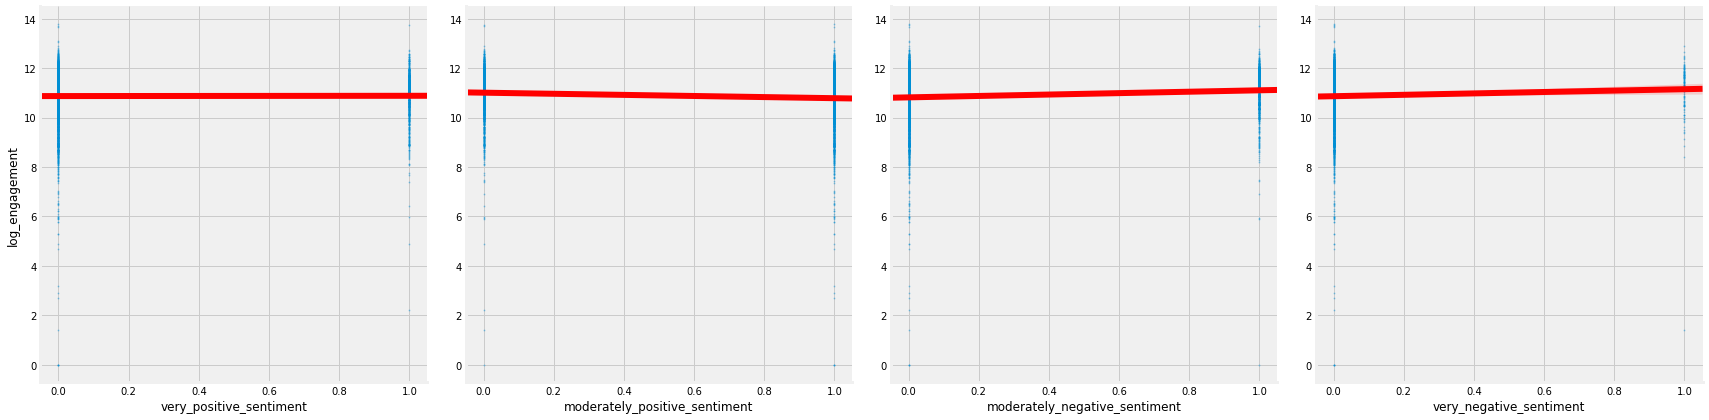

In [52]:
sns.pairplot(dummy_trumptweets,
            x_vars=['very_positive_sentiment', 'moderately_positive_sentiment', 'moderately_negative_sentiment',
                    'very_negative_sentiment'],
            y_vars='log_engagement',
            kind='reg',
            plot_kws={'scatter_kws': {'s':1, 'alpha':.3},
                      'line_kws': {'color':'red'}
                     },
            size=6
            );

**Testing Polynomial Features on Sentiment**

In [60]:
#Testing Polynomial Features on Sentiment

from sklearn.preprocessing import PolynomialFeatures

X = (dummy_trumptweets.loc[:, ['sentiment']])

pf = PolynomialFeatures(degree=1, include_bias=False)
pf.fit(X)
X = pf.transform(X)

y = dummy_trumptweets.loc[:, 'log_engagement']

In [61]:
lr = LinearRegression()
lr.fit(X, y)

y_fit = lr.predict(X)


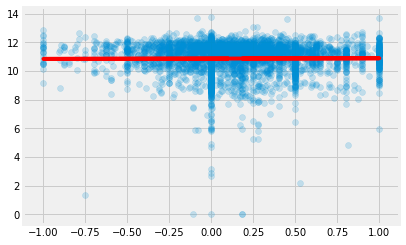

In [62]:
plt.plot(dummy_trumptweets.loc[:, 'sentiment'].values, y_fit, color='r')
plt.scatter(dummy_trumptweets.loc[:, 'sentiment'], y, alpha=.2)

**Testing Log features on Sentiment**

In [63]:
# Using 2 parameter Box-Cox transformation of log(x + 1.1) to transform all values greater than 0

dummy_trumptweets.loc[:, 'log_sentiment'] = np.log(dummy_trumptweets.loc[:, 'sentiment'] + 1.1)

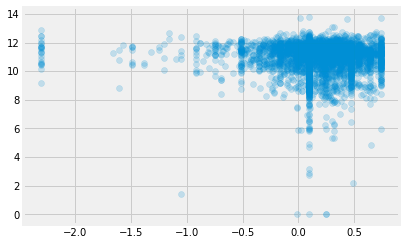

In [64]:
x =  dummy_trumptweets.loc[:, 'log_sentiment']
y = dummy_trumptweets.loc[:, 'log_engagement']
plt.scatter(x, y, alpha=.2)
plt.show()

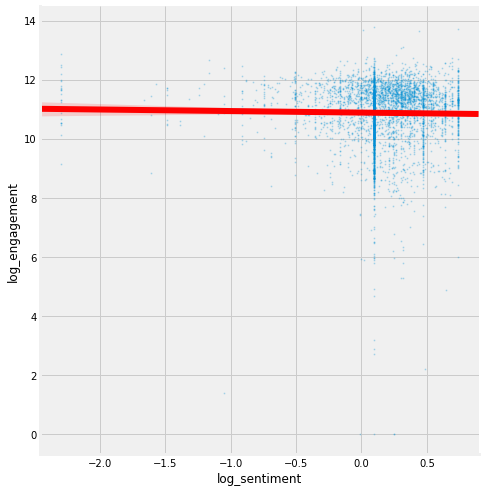

In [27]:
sns.pairplot(dummy_trumptweets,
            x_vars='log_sentiment',
            y_vars='log_engagement',
            kind='reg',
            plot_kws={'scatter_kws': {'s':1, 'alpha':.2},
                      'line_kws': {'color':'red'}
                     },
            size=7
            );

# Analysis and Visualizations

In [28]:
dummy_trumptweets.source.value_counts()

Twitter for iPhone     3341
Twitter for Android     861
Twitter Web Client      195
Media Studio            130
Twitter Ads              94
Twitter for iPad         51
TweetDeck                 2
Periscope                 1
Name: source, dtype: int64

In [29]:
#describe all

dummy_trumptweets.describe(include='all')

,source,text,retweet_count,favorite_count,is_retweet,id_str,src_android,src_webclient,src_mediastudio,src_twitterads,...,tweet_hour,is_afternoon,is_evening,is_latenight,log_engagement,sentiment,moderately_positive_sentiment,moderately_negative_sentiment,very_negative_sentiment,log_sentiment
count,4675,4675,4675.000000,4675.000000,4675,4.675000e+03,4675.000000,4675.000000,4675.000000,4675.000000,...,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000,4675.000000
unique,8,4665,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Twitter for iPhone,MAKE AMERICA GREAT AGAIN!,NaN,NaN,False,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3341,7,NaN,NaN,4228,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,16402.736898,60308.453904,NaN,8.542120e+17,0.184171,0.041711,0.027807,0.020107,...,12.643636,0.278503,0.263529,0.019037,10.874569,0.143641,0.606203,0.191016,0.026738,0.168570
std,NaN,NaN,13960.319769,48323.015209,NaN,6.611347e+16,0.387665,0.199950,0.164438,0.140381,...,6.973148,0.448310,0.440594,0.136671,1.084766,0.354736,0.488643,0.393144,0.161334,0.348719
min,NaN,NaN,0.000000,0.000000,NaN,7.549926e+17,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-2.302585
25%,NaN,NaN,8770.000000,23298.500000,NaN,7.889149e+17,0.000000,0.000000,0.000000,0.000000,...,10.000000,0.000000,0.000000,0.000000,10.389703,0.000000,0.000000,0.000000,0.000000,0.095310
50%,NaN,NaN,13781.000000,55454.000000,NaN,8.569286e+17,0.000000,0.000000,0.000000,0.000000,...,13.000000,0.000000,0.000000,0.000000,11.133435,0.008333,1.000000,0.000000,0.000000,0.102857
75%,NaN,NaN,20583.000000,86214.000000,NaN,9.131525e+17,0.000000,0.000000,0.000000,0.000000,...,19.000000,1.000000,1.000000,0.000000,11.571878,0.350000,1.000000,0.000000,0.000000,0.371564


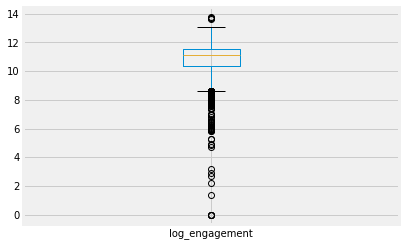

In [30]:
#boxplot of log(engagement)

dummy_trumptweets.loc[:,'log_engagement'].plot(kind='box')

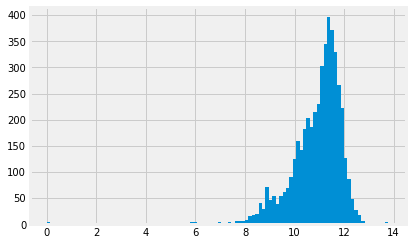

In [31]:
#Histogram of log(engagement)

dummy_trumptweets.loc[:, 'log_engagement'].hist(bins=100)

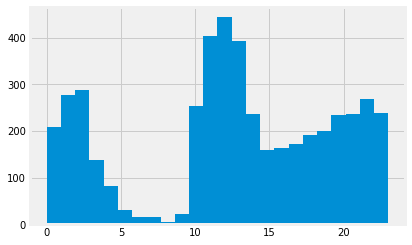

In [32]:
#Histogram of tweet_hour 

dummy_trumptweets.loc[:, 'tweet_hour'].hist(bins=24)

In [33]:
dummy_trumptweets.columns

Index(['source', 'text', 'retweet_count', 'favorite_count', 'is_retweet',
       'id_str', 'src_android', 'src_webclient', 'src_mediastudio',
       'src_twitterads', 'src_ipad', 'src_tweetdeck', 'src_periscope',
       'engagement', 'tweet_hour', 'is_afternoon', 'is_evening',
       'is_latenight', 'log_engagement', 'sentiment',
       'moderately_positive_sentiment', 'moderately_negative_sentiment',
       'very_negative_sentiment', 'log_sentiment'],
      dtype='object')

In [34]:
feature_cols = ['is_retweet', 
                'is_afternoon', 
                'is_evening', 
                'is_latenight', 
                'moderately_positive_sentiment',
                'moderately_negative_sentiment', 
                'very_negative_sentiment']

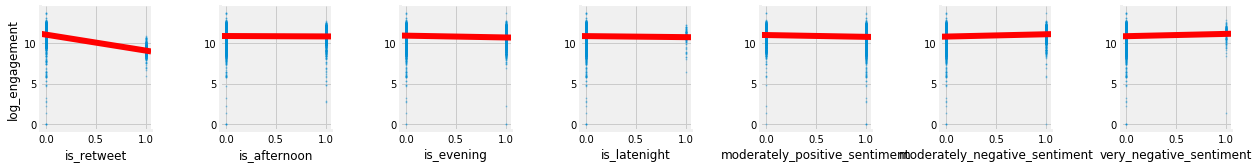

In [35]:
sns.pairplot(dummy_trumptweets,
            x_vars=feature_cols,
            y_vars='log_engagement',
            kind='reg',
            plot_kws={'scatter_kws': {'s':1, 'alpha':.3},
                      'line_kws': {'color':'red'}
                     }
            );

In [36]:
# Embiggen the negative sentiment charts



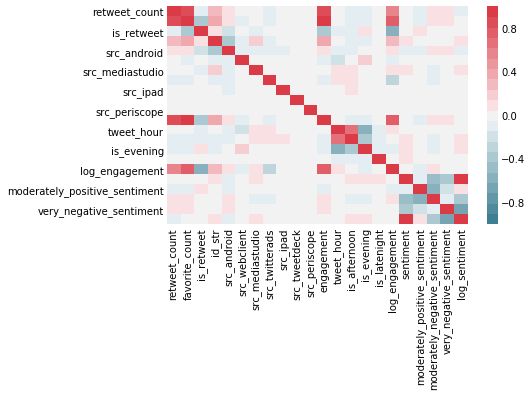

In [37]:
#Insert Correlation Matrix with HeatMap

sns.heatmap(dummy_trumptweets.corr(),
            vmin=-1,
            vmax = 1,
            cmap = sns.diverging_palette(220, 10, n=21),
            );

is_retweet


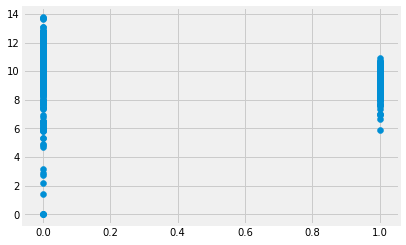

is_afternoon


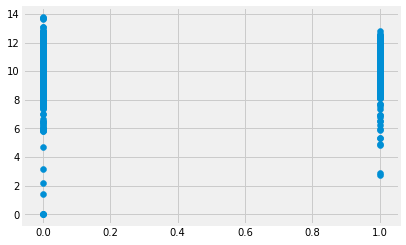

is_evening


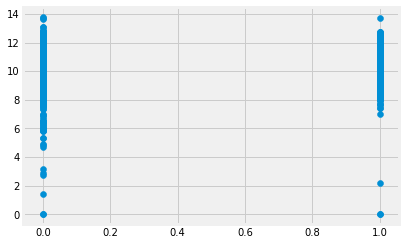

is_latenight


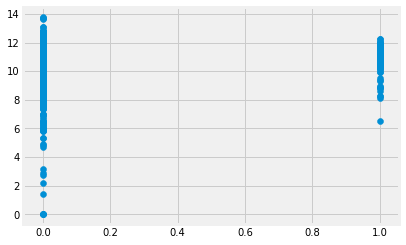

moderately_positive_sentiment


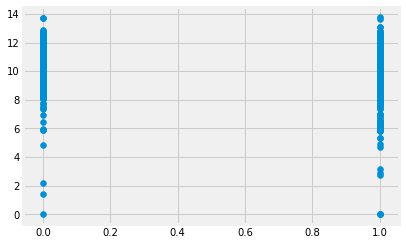

moderately_negative_sentiment


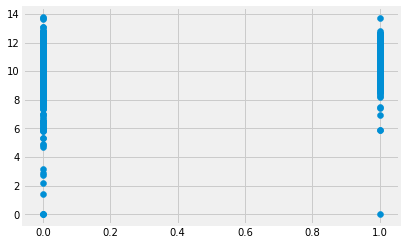

very_negative_sentiment


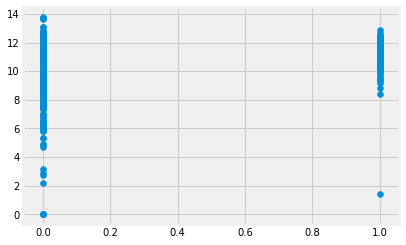

In [38]:
#Review Scatter Plots

y = dummy_trumptweets.loc[:, 'log_engagement']

for var in feature_cols:
    print(var)
    x = dummy_trumptweets.loc[:, var]
    plt.scatter(x, y)
    plt.show()

# Linear Regression

In [39]:
X = dummy_trumptweets.loc[:, feature_cols]
y = dummy_trumptweets.loc[:, 'log_engagement']


In [40]:
#Split Train and Test

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [41]:
# model on the training set of data

lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# predict on the test set for X

y_pred = lr.predict(X_test)

In [43]:
# compare predicted results against the test set

#print(metrics.mean_squared_error(y_train, lr.predict(X_train)))

print(metrics.mean_squared_error(y_test, y_pred))

0.81435367821


In [44]:
#Create Benchmark of Mean Values

y_pred_null = np.ones(y_test.shape) * y_train.mean()

#compare y_test against the y_means
metrics.mean_squared_error(y_test, y_pred_null)

1.1827115079589294

In [45]:
print(lr.intercept_)
print(lr.coef_)

11.226384712
[-1.97232317 -0.25955238 -0.24490816 -0.28486298 -0.08210169  0.10024365
  0.22730542]


# Conclusion

lorem ipsum

Run metrics

Run Cross Validations

dig into the #hashtags

In [46]:
#run metrics on both the test and train set